# Final Presentation demo

In [20]:
# imports

from contextlib import nullcontext
from PIL import Image
from typing import List, Union, Tuple

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import DDIMScheduler, StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel
import torch
from torchvision.models import resnet50, ResNet50_Weights, ResNet
from torch.cuda.amp import autocast
import torch.nn as nn
from torchvision.transforms.functional import pil_to_tensor
from tqdm.auto import tqdm
from functools import partial
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/lucienwalewski/Library/CloudStorage/OneDrive-Personal/ETH/Year 1/Spring/Generative Visual Models/Project/Latent-DIRE')
sys.path.append('/Users/lucienwalewski/Library/CloudStorage/OneDrive-Personal/ETH/Year 1/Spring/Generative Visual Models/Project/Latent-DIRE/src')
from src.training import Classifier

pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", safety_checker=None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline.to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
class LatentDIRE(nn.Module):
    """Based on
    https://github.com/huggingface/diffusers/blob/3045fb276352681f6b9075956e599dd8ef571872/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L56.
    https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline#understanding-pipelines-models-and-schedulers.
    https://github.com/tejank10/null-text-inversion
    """

    def __init__(
        self,
        device: torch.device,
        pretrained_model_name: str = "runwayml/stable-diffusion-v1-5",
        generator: torch.Generator = torch.Generator().manual_seed(1),
        use_fp16: bool = True,
        n_steps: int = 20,  # cf. section 4.1 in the DIRE paper
    ) -> None:
        super().__init__()
        self.device = device
        self.generator = generator
        self.use_fp16 = use_fp16
        self.n_steps = n_steps

        assert pretrained_model_name in [
            "CompVis/stable-diffusion-v1-4",
            "runwayml/stable-diffusion-v1-5",
            # "stabilityai/stable-diffusion-2-1", TODO: enable prediction_type=v_predict in _ddim_inversion
        ], f"Model {pretrained_model_name} not supported. Must be one of 'CompVis/stable-diffusion-v1-4', 'runwayml/stable-diffusion-v1-5'"  # , 'stabilityai/stable-diffusion-2-1'"
        self.scheduler = DDIMScheduler.from_pretrained(pretrained_model_name, subfolder="scheduler")
        self.pipe = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name,
            safety_checker=None,
            scheduler=self.scheduler,
            torch_dtype=torch.float16 if use_fp16 else torch.float32,
        ).to(device)
        self.vae = AutoencoderKL.from_pretrained(pretrained_model_name, subfolder='vae')
        self.tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name, subfolder='tokenizer')
        self.text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name, subfolder='text_encoder')
        self.unet = UNet2DConditionModel.from_pretrained(pretrained_model_name, subfolder='unet')

    @torch.no_grad()
    def forward(
        self,
        x: torch.Tensor,
        n_steps: int = None,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Compute DIRE(x).

        Args:
            x (torch.Tensor):
                Batch of images.
            n_steps (int, optional):
                Number of steps to take. Defaults to 20.
        Returns:
            Tuple[torch.Tensor, ...]: DIRE(x), DIRE(z), reconstruction, latent_reconstruction, latent
        """
        if n_steps is None:
            n_steps = self.n_steps
        latent = self.encode(x)
        noise = self._ddim_inversion(latent, n_steps)
        batch_size = noise.shape[0]
        noise = noise.to(dtype=torch.float16 if self.use_fp16 else torch.float32)
        # latent_reconstruction = self.pipe(
        #     prompt=[""] * batch_size,
        #     latents=noise,
        #     num_inference_steps=n_steps,
        #     output_type="latent",
        #     generator=self.generator,
        # ).images

        ################

        latents = noise * self.scheduler.init_noise_sigma

        self.scheduler.set_timesteps(n_steps)

        text_input = self.tokenizer(
            "", padding="max_length", max_length=self.tokenizer.model_max_length, truncation=True, return_tensors="pt"
        )

        with torch.no_grad():
            text_embeddings = self.text_encoder(text_input.input_ids.to('cpu'))[0]
        
        max_length = text_input.input_ids.shape[-1]
        uncond_input = self.tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
        uncond_embeddings = self.text_encoder(uncond_input.input_ids.to('cpu'))[0]

        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        text_embeddings = self.pipe._encode_prompt("", 'cpu', 1, True)


        for t in tqdm(self.scheduler.timesteps):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)

            latent_model_input = self.scheduler.scale_model_input(latent_model_input, timestep=t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + 8 * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

        # latents = 1 / 0.18215 * latents

        #################

        latent_reconstruction = latents

        latent_dire = torch.abs(latent - latent_reconstruction)
        reconstruction = self.decode(latent_reconstruction)
        dire = torch.abs(x - reconstruction)

        return dire, latent_dire, reconstruction, latent_reconstruction, latent

    def _ddim_inversion(self, latent: torch.Tensor, n_steps: int = None) -> torch.Tensor:
        """
        adapted from
        https://github.com/tejank10/null-text-inversion/blob/main/notebook.ipynb
        """
        if n_steps is None:
            n_steps = self.n_steps
        batch_size = latent.shape[0]
        encoder_hidden_state = self.pipe._encode_prompt(
            [""] * batch_size,
            device=self.device,
            num_images_per_prompt=1,
            do_classifier_free_guidance=False,
        )
        self.scheduler.set_timesteps(n_steps)
        reverse_timestep_list = reversed(self.scheduler.timesteps)

        for i in tqdm(range(len(reverse_timestep_list) - 1), desc="inversion"):
            timestep = reverse_timestep_list[i]
            next_timestep = reverse_timestep_list[i + 1]
            latent_model_input = self.scheduler.scale_model_input(latent, timestep)
            with autocast() if self.use_fp16 else nullcontext():
                noise_pred = self.pipe.unet(latent_model_input, timestep, encoder_hidden_state).sample

            alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
            alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
            beta_prod_t = 1 - alpha_prod_t
            beta_prod_t_next = 1 - alpha_prod_t_next

            pred_x0 = (latent - beta_prod_t**0.5 * noise_pred) / (alpha_prod_t**0.5)
            latent = alpha_prod_t_next**0.5 * pred_x0 + beta_prod_t_next**0.5 * noise_pred

            # # Every quarter of the way, print the representation
            # if i % (len(reverse_timestep_list) // 4) == 0:
            #     decoded_latent = self.decode(latent)
            #     img = model.tensor_to_pil(decoded_latent[0].unsqueeze(0))
            #     # print the image
            #     # img[0].show()
            #     plt.imshow(img[0])

        return latent

    @torch.no_grad()
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        with autocast() if self.use_fp16 else nullcontext():
            # fh: TODO: Use mean instead of sample?
            latent = self.pipe.vae.encode(x).latent_dist.sample(generator=self.generator)
        latent *= self.pipe.vae.config.scaling_factor

        return latent

    @torch.no_grad()
    def decode(self, latent: torch.Tensor) -> torch.Tensor:
        """
        adapted from
        https://github.com/huggingface/diffusers/blob/4d35d7fea3208ddf1599e90b23ee95095b280646/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L441
        """
        latent /= self.pipe.vae.config.scaling_factor
        with autocast() if self.use_fp16 else nullcontext():
            image = self.pipe.vae.decode(latent).sample
        image = image.float()

        return image

    @staticmethod
    def img_to_tensor(image: Union[str, Image.Image], size: int, use_fp16: bool = False) -> torch.Tensor:
        if type(image) == str:
            image = Image.open(image)
        image = image.resize((size, size))
        # image = image.convert("RGB")
        t = pil_to_tensor(image)
        t = t.to(dtype=torch.float16 if use_fp16 else torch.float32)
        t = t / 127.5 - 1.0  # [0, 255] to [-1, 1]
        t = t.unsqueeze(0)

        return t

    @staticmethod
    def tensor_to_pil(image: torch.Tensor) -> List[Image.Image]:
        """
        adapted from
        https://github.com/huggingface/diffusers/blob/716286f19ddd9eb417113e064b538706884c8e73/src/diffusers/pipelines/pipeline_utils.py#L815
        """
        if image.dim == 3:
            image = image.unsqueeze(0)

        image = ((image + 1) * 127.5).clamp(0, 255).to(dtype=torch.uint8)  # [-1, 1] to [0, 255]
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        if image.shape[-1] == 1:
            # special case for grayscale (single channel) image
            pil_image = [Image.fromarray(image.squeeze(), mode="L") for image in image]
        else:
            pil_image = [Image.fromarray(image) for image in image]

        return pil_image


model = LatentDIRE('cpu', use_fp16=False)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [15]:
classifier = Classifier.load_from_checkpoint('../model_weights/ResNet50_DIRE.ckpt', map_location=torch.device('cpu'))
classifier.eval()

Classifier(
  (classifier): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [14]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = partial(model.img_to_tensor, size=512)
dataset = ImageFolder('../data/examples/generated_nested/', transform=transform)
dataloader = DataLoader(dataset, 1, shuffle=False)

# for idx, (batch, _) in tqdm(enumerate(dataloader)):
#     batch = batch.squeeze(1)
#     dire, ldire, *_ = model(batch, n_steps=4)
#     decoded_ldire = model.decode(ldire)
#     decoded_ldire = model.tensor_to_pil(decoded_ldire)
#     dire_image = model.tensor_to_pil(dire)
#     # Cannot plot ldire
#     break

### Creating a fake image

100%|██████████| 50/50 [10:38<00:00, 12.78s/it]


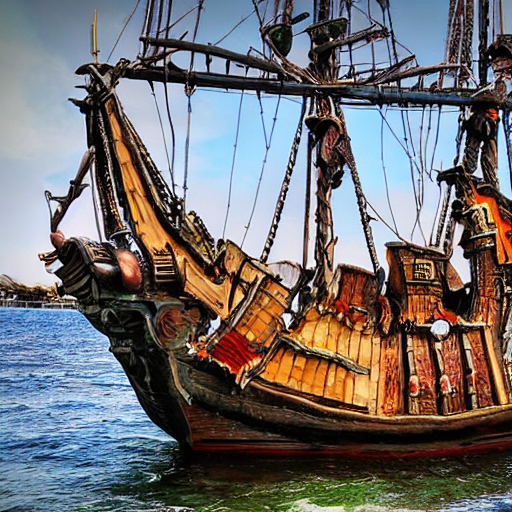

In [2]:
prompt = "A pirate ship"
image = pipeline(prompt, num_images_per_prompt=1).images[0]
image

In [13]:
image_tensor = model.img_to_tensor(image, size=512)
dire, latent_dire, reconstruction, latent_reconstruction, latent = model(image_tensor)

100%|██████████| 20/20 [04:08<00:00, 12.42s/it]


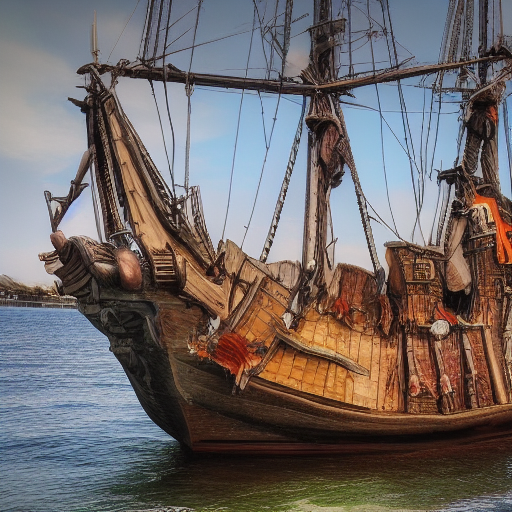

In [14]:
model.tensor_to_pil(reconstruction)[0]

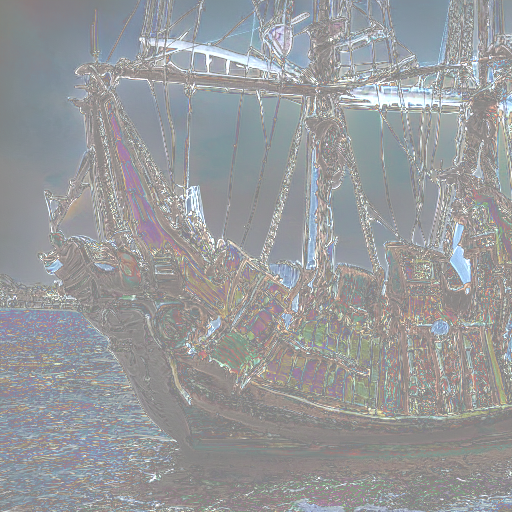

In [20]:
dire_image = model.tensor_to_pil(dire)[0]
dire_image

In [23]:
latent_dire_pil = model.tensor_to_pil(latent_dire)[0]

In [18]:
prediction = classifier.classifier(dire.unsqueeze(0)).argmax(axis=1)
if prediction == 0:
    print('Generated image is fake')
else:
    print('Generated image is real')
# classifier.classifier(dire[0].unsqueeze(0)).argmax(axis=1)

Predicted class: tensor([1])
